# Projeto 1: Regressão Linear

O projeto consiste em explorar modelos de regressão linear para prever o volume de tráfego do [Metro Interstate](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) a partir de 8 _features_ :

- Feriado (ou dia útil)
- Temperatura (em Kelvin)
- Chuva (em 1h)
- Neve (em 1h)
- Nuvens (porcentagem)
- Clima (curto)
- Clima (longo)
- Data/Hora

O valor alvo é o volume de tráfego, que também está disponível no _dataset_.

In [1]:
import re
import time
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date as date_check 
from random import randint, sample
from sklearn import linear_model

Primeiro, podemos __visualizar__ os dados por meio da biblioteca de visualização abaixo:

In [2]:
def date_split(string):
    ''' Read date-time in "yyyy-mm-dd hh:mm:ss" and cast to int.

        Parameters:
            string (string): string containing the mentioned format.

        Returns:
            (dictionary): contains date-time info indexed by initials.
    '''

    date = re.split("-|:| ", string)
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    hour = int(date[3])

    return {"h":hour, "d":day, "m":month, "y":year}

# Plots a relation between the average daily traffic per hour
def avg_traffic_hour_daily(data):
    # OBS: there are duplicated time stamps to separate more than one
    # enviromental condition (p.e. if its foggy and cloudy there will be duplicates)
    curr_day = 0
    traffic_hour = []
    for x in data[1:] :
        hour, day, _, _ = date_split(x[7]).values()
        if (day != curr_day):
            curr_day = day
            traffic_hour.append(np.array([0]*24))
        traffic_hour[-1][hour] = x[-1]

    avg = sum(traffic_hour)/len(traffic_hour)
    plt.plot(range(0,24), avg)
    plt.title("Análise do tráfego por hora")
    plt.xlabel("Horas do dia (00h-24h)")
    plt.ylabel("Média diária de tráfego")
    plt.show()

    return

# Plot a realtion between weather descriptions and the average daily traffic per hour
def avg_traffic_per_weather(data):

    desc_main = {y:[0,0] for y in list(set([x[5] for x in data[1:]]))}
    desc = {y:[0,0] for y in list(set([x[6] for x in data[1:]]))}
    
    for x in data[1:]:
        desc_main[x[5]][0] += 1
        desc_main[x[5]][1] += int(x[-1])
        desc[x[6]][0] += 1
        desc[x[6]][1] += int(x[-1])

    counts = [x[0] if x[0]>0 else 1 for x in desc_main.values()]
    sums = [x[1] for x in desc_main.values()]
    desc_main_avg = np.array(sums)/np.array(counts)

    counts = [x[0] if x[0]>0 else 1  for x in desc.values()]
    sums = [x[1] for x in desc.values()]
    desc_avg = np.array(sums)/np.array(counts)
    
    a = plt.figure(1)
    plt.plot(list(desc.keys()), desc_avg)
    plt.xticks(list(desc.keys()), rotation='vertical')
    plt.margins(0)
    plt.subplots_adjust(bottom=0.5)
    plt.title("Análise do tráfego por descrição específica do clima")
    plt.xlabel("Descrições específicas do clima")
    plt.ylabel("Média diária de tráfego")
    plt.grid(True)
    
    b = plt.figure(2)
    plt.plot(list(desc_main.keys()), desc_main_avg)
    plt.title("Análise do tráfego por descrição geral do clima")
    plt.xlabel("Descrições gerais do clima")
    plt.ylabel("Média diária de tráfego")
    plt.grid(True)
    plt.show()
    input()
    
    return


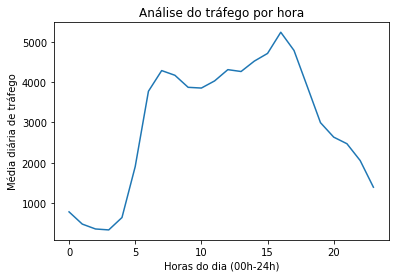

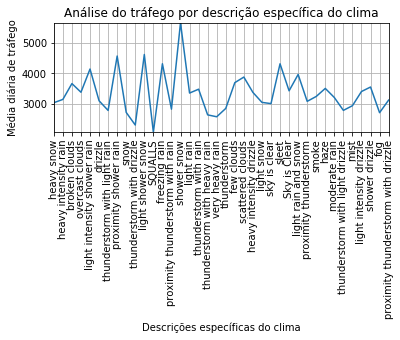

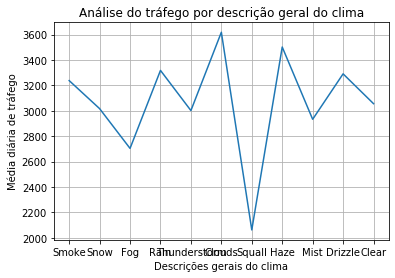

In [ ]:
dataset = open('Datasets/dataset_with_column_names.csv')
data = list(map(lambda x: x.split(","), dataset.readlines()))
avg_traffic_hour_daily(data)
avg_traffic_per_weather(data)

Pode-se notar relações entre algumas _features_ e o valor objetivo. A relação mais clara e fácil de explicar é vista em horários de pico durante o dia. 

Feito isso, podemos criar o __modelo__ que vamos usar para o treinamento. Para isso, passamos o _dataset_ por duas etapas: __pré-processamento__ (para "limpar" o conjunto de dados e criar o modelo que queremos) e __normalização__ (importante para o treinamento).